# 基于位置方差的机器人运动学参数标定

目标函数:最小化观测点位置方差
目标精度:位置标准差1mm以内

In [1]:
import torch
import numpy as np


print("=== Position Variance-Based Robot Kinematics Parameter Calibration Demo ===")
print("Objective Function: Minimize variance of observed positions")
print("Target precision: Position standard deviation < 1 mm")

=== Position Variance-Based Robot Kinematics Parameter Calibration Demo ===
Objective Function: Minimize variance of observed positions
Target precision: Position standard deviation < 1 mm


## 1. 创建机器人模型

In [2]:
from robot_model.robots import create_robot
import numpy as np

# 使用现成的机器人创建函数
robot_name = "ABB6700"  # 设置机器人名称
robot = create_robot(robot_name=robot_name)

print(f"Created robot: {robot.name}")
print(f"Robot DOF: {robot.n}")

# 打印机器人参数
print("\nRobot DH Parameters:")
for i, link in enumerate(robot.links):
    print(f"Link {i+1}: a={link.a.item():.1f}mm, d={link.d.item():.1f}mm, "
          f"alpha={np.degrees(link.alpha.item()):.1f}°, beta={np.degrees(link.beta.item()):.1f}°, "
          f"theta_offset={np.degrees(link.offset.item()):.1f}°")

# 打印base变换
print("\nBase Transform (World to Robot Base):")
if hasattr(robot, 'base') and robot.base is not None:
    base_pos = robot.base[0:3, 3]
    print(f"  Translation: x={base_pos[0]:.1f}mm, y={base_pos[1]:.1f}mm, z={base_pos[2]:.1f}mm")
    print(f"  Base transform shape: {robot.base.shape}")
else:
    print("  No base transform defined")

# 打印手眼参数(现在是可校准的)
print("\nHand-Eye Parameters (Calibratable):")
print(f"  Translation: tx={robot.tx.item():.1f}mm, ty={robot.ty.item():.1f}mm, tz={robot.tz.item():.1f}mm")
print(f"  Rotation: rx={robot.rx.item():.3f}rad, ry={robot.ry.item():.3f}rad, rz={robot.rz.item():.3f}rad")
print(f"  Tool transform shape: {robot.tool.shape}")

# 测试前向运动学
q_test = [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]  # 6个关节角度
print(f"\nTest joint angles: {q_test}")
T_test = robot.fkine(q_test)
print(f"Forward kinematics test passed")
print(f"End effector position: {T_test[0:3, 3].detach().numpy()}")
print(f"End effector position (mm): {T_test[0:3, 3].detach().numpy()}")

Created robot: ABB6700_Calibration_Robot
Robot DOF: 6

Robot DH Parameters:
Link 1: a=320.0mm, d=780.0mm, alpha=-90.0°, beta=0.0°, theta_offset=0.0°
Link 2: a=1125.0mm, d=0.0mm, alpha=0.0°, beta=0.0°, theta_offset=-90.0°
Link 3: a=200.0mm, d=-0.0mm, alpha=-90.0°, beta=0.0°, theta_offset=0.0°
Link 4: a=0.0mm, d=1392.5mm, alpha=-90.0°, beta=0.0°, theta_offset=-180.0°
Link 5: a=-0.0mm, d=0.0mm, alpha=-90.0°, beta=0.0°, theta_offset=-180.0°
Link 6: a=-0.0mm, d=200.0mm, alpha=-0.0°, beta=0.0°, theta_offset=180.0°

Base Transform (World to Robot Base):
  Translation: x=0.0mm, y=0.0mm, z=0.0mm
  Base transform shape: torch.Size([4, 4])

Hand-Eye Parameters (Calibratable):
  Translation: tx=0.0mm, ty=0.0mm, tz=0.0mm
  Rotation: rx=0.000rad, ry=0.000rad, rz=0.000rad
  Tool transform shape: torch.Size([4, 4])

Test joint angles: [0.1, 0.2, 0.3, 0.1, 0.2, 0.1]
Forward kinematics test passed
End effector position: [2004.02537535  205.05991332 1261.82201599]
End effector position (mm): [2004.025375

## 2.手眼预标定

In [3]:
# 直接使用提供的手眼参数并应用到机器人模型
import numpy as np
import torch

# 提供的手眼参数
tx = 3.944  # mm
ty = 197.431  # mm  
tz = 53.414  # mm
rx = -0.053095  # rad
ry = -0.260197  # rad
rz = -3.109527  # rad

# 将参数应用到机器人模型
robot.tx.data = torch.tensor(tx, dtype=torch.float64)
robot.ty.data = torch.tensor(ty, dtype=torch.float64)
robot.tz.data = torch.tensor(tz, dtype=torch.float64)
robot.rx.data = torch.tensor(rx, dtype=torch.float64)
robot.ry.data = torch.tensor(ry, dtype=torch.float64)
robot.rz.data = torch.tensor(rz, dtype=torch.float64)

print("手眼参数已应用到机器人模型:")
print(f"Translation: tx={robot.tx.item():.3f}mm, ty={robot.ty.item():.3f}mm, tz={robot.tz.item():.3f}mm")
print(f"Rotation: rx={robot.rx.item():.6f}rad, ry={robot.ry.item():.6f}rad, rz={robot.rz.item():.6f}rad")

# 获取更新后的手眼变换矩阵
hand_eye_transform = robot.tool.detach().numpy()
print("\n更新后的手眼变换矩阵:")
print(hand_eye_transform)

手眼参数已应用到机器人模型:
Translation: tx=3.944mm, ty=197.431mm, tz=53.414mm
Rotation: rx=-0.053095rad, ry=-0.260197rad, rz=-3.109527rad

更新后的手眼变换矩阵:
[[-9.65842559e-01  3.09809919e-02 -2.57270926e-01  3.94400000e+00]
 [-4.56613435e-02 -9.97639727e-01  5.12836825e-02  1.97431000e+02]
 [-2.55074877e-01  6.12792993e-02  9.64977541e-01  5.34140000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## 3. 创建校准器

In [4]:
from main_cali.calibrator import RobotCalibrator

# 创建高精度校准器,使用新的排除规则
calibrator = RobotCalibrator(
    robot, 
    calibration_params=['a', 'alpha', 'd', 'beta', 'offset', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz'], 
    excluded_params={
        0: ['d','beta'],           # 排除第一关节(索引0)的d和beta参数
        1: ['d'],                   # 排除第二关节(索引1)的d参数  
        2: ['d','beta'],                   # 排除第三关节(索引2)的d参数
        3: ['beta'],           # 排除第四关节(索引3)的d和beta参数
        4: ['beta'],               # 排除第五关节(索引4)的beta参数
        5: ['a', 'alpha', 'd', 'beta', 'offset']                # 排除第六关节(索引5)的所有参数
    },
    target_precision=1e-4,
    enable_outlier_detection=False
)
print(f"Created high-precision calibrator")
print(f"Calibration parameters: {calibrator.calibration_params}")
print(f"Target precision (variance): {calibrator.target_precision:.2e}")
print("Excluded parameters:")
print("  Joint 0 (Link 1): d, beta")
print("  Joint 1 (Link 2): d") 
print("  Joint 2 (Link 3): d")
print("  Joint 3 (Link 4): d, beta")
print("  Joint 4 (Link 5): beta")
print("  Joint 5 (Link 6): beta")
print("Note: Hand-eye parameters (tx, ty, tz, rx, ry, rz) included for calibration")

Created high-precision calibrator
Calibration parameters: ['a', 'alpha', 'd', 'beta', 'offset', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz']
Target precision (variance): 1.00e-04
Excluded parameters:
  Joint 0 (Link 1): d, beta
  Joint 1 (Link 2): d
  Joint 2 (Link 3): d
  Joint 3 (Link 4): d, beta
  Joint 4 (Link 5): beta
  Joint 5 (Link 6): beta
Note: Hand-eye parameters (tx, ty, tz, rx, ry, rz) included for calibration


## 4. 读取观测数据

In [5]:
from main_cali.calibrator import RobotCalibrator
import os

print("=== 读取观测数据 ===")

# 配置main_data数据路径 - 使用新格式的observations.json文件
data_file = os.path.join(os.getcwd(), "data", "main_data", "ABB_2", "observations.json")

print("正在加载预处理的观测数据...")
print(f"数据文件路径: {data_file}")

# 检查数据文件是否存在
if not os.path.exists(data_file):
    print(f"❌ 观测数据文件 {data_file} 不存在")
    print("请先运行数据预处理程序生成observations.json文件")
    observations = None
else:
    try:
        # 直接从JSON文件加载观测数据
        print("正在从JSON文件加载观测数据...")
        success = calibrator.load_observations_from_json(data_file)
        
        if success:
            observations = calibrator.observations
            print(f"✓ 观测数据已成功设置到校准器")
            
            # 显示数据格式信息
            print(f"\n=== 数据格式信息 ===")
            print(f"观测数据数量: {len(observations)}")
            sample_obs = observations[0]
            print(f"样本观测数据结构:")
            for key in sample_obs.keys():
                if key == 'joint_state':
                    print(f"  {key}: {type(sample_obs[key])} (长度: {len(sample_obs[key])})")
                elif key == 'point_cloud_center':
                    print(f"  {key}: {type(sample_obs[key])} (维度: {sample_obs[key].shape if hasattr(sample_obs[key], 'shape') else len(sample_obs[key])})")
                else:
                    print(f"  {key}: {type(sample_obs[key])}")
        else:
            print("❌ 观测数据加载失败")
            observations = None
                
    except Exception as e:
        print(f"❌ 数据加载过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()
        observations = None

# 检查最终结果
if observations is None or len(observations) == 0:
    print("❌ 无法设置观测数据到校准器，请检查数据文件")

=== 读取观测数据 ===
正在加载预处理的观测数据...
数据文件路径: d:\桌面\实习\diff_cali\data\main_data\ABB_2\observations.json
正在从JSON文件加载观测数据...
Loaded 30 observations with precomputed centers
✓ 成功从 d:\桌面\实习\diff_cali\data\main_data\ABB_2\observations.json 加载 30 个观测数据
✓ 观测数据已成功设置到校准器

=== 数据格式信息 ===
观测数据数量: 30
样本观测数据结构:
  id: <class 'int'>
  joint_state: <class 'list'> (长度: 6)
  point_cloud_center: <class 'list'> (维度: 3)


Calculating end effector positions from observations...
Calculated 30 end effector positions


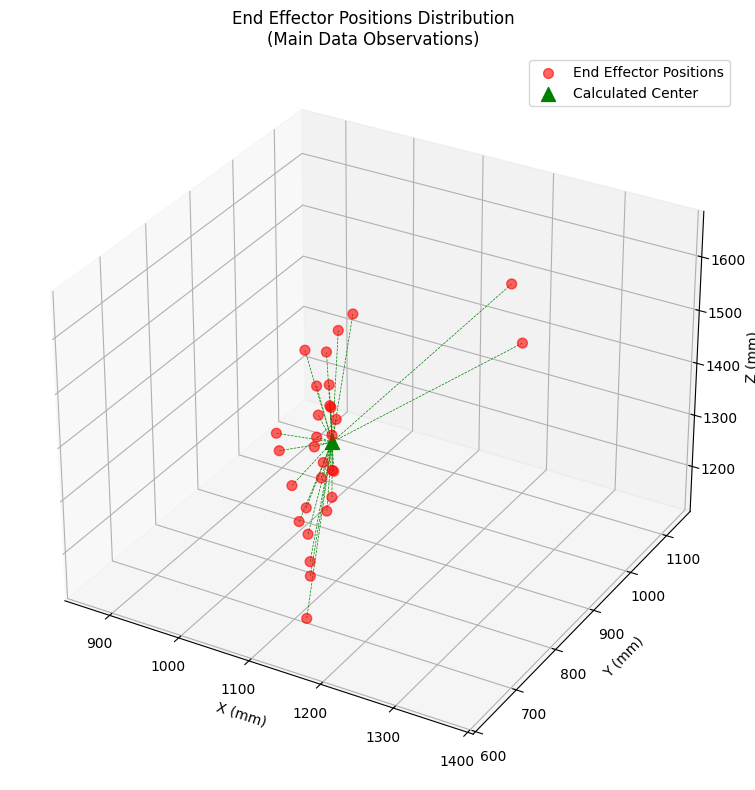


=== End Effector Position Statistics ===
Number of positions: 30
Calculated center: [1116.4, 765.6, 1407.0] mm
Mean distance from center: 164.95 mm
Distance std dev: 84.13 mm
Position range:
  X: 1037.0 to 1204.5 mm
  Y: 594.1 to 1167.4 mm
  Z: 1188.8 to 1605.7 mm
Estimated workspace volume: 0.04 m³


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# 检查是否有观测数据
if 'observations' not in locals() or observations is None or len(observations) == 0:
    print("❌ 没有可用的观测数据进行可视化")
else:
    # 计算所有观测点的末端位置
    print("Calculating end effector positions from observations...")
    end_positions = []
    joint_positions = []

    for obs in observations:
        q = obs['joint_state']
        joint_positions.append(q)
        
        # 使用机器人计算末端位置
        T = robot.fkine(q)
        pos = T[0:3, 3].detach().numpy()
        end_positions.append(pos)

    end_positions = np.array(end_positions)
    print(f"Calculated {len(end_positions)} end effector positions")

    # 创建3D可视化
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制末端位置点
    ax.scatter(end_positions[:, 0], end_positions[:, 1], end_positions[:, 2], 
               c='red', alpha=0.6, s=50, label='End Effector Positions')

    # 计算并显示位置统计
    center_calc = np.mean(end_positions, axis=0)
    ax.scatter(center_calc[0], center_calc[1], center_calc[2], 
               c='green', s=100, marker='^', label='Calculated Center')
    
    # 从每个点到中心的连线
    for i, pos in enumerate(end_positions):
        ax.plot([pos[0], center_calc[0]], [pos[1], center_calc[1]], [pos[2], center_calc[2]], 
                'g--', alpha=1, linewidth=0.5)

    # 设置图形属性
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title('End Effector Positions Distribution\n(Main Data Observations)')
    ax.legend()

    # 添加网格
    ax.grid(True, alpha=0.3)

    # 设置相等的坐标轴比例
    max_range = np.array([end_positions[:,0].max()-end_positions[:,0].min(),
                          end_positions[:,1].max()-end_positions[:,1].min(),
                          end_positions[:,2].max()-end_positions[:,2].min()]).max() / 2.0
    mid_x = (end_positions[:,0].max()+end_positions[:,0].min()) * 0.5
    mid_y = (end_positions[:,1].max()+end_positions[:,1].min()) * 0.5
    mid_z = (end_positions[:,2].max()+end_positions[:,2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.tight_layout()
    plt.show()

    # 打印统计信息
    print(f"\n=== End Effector Position Statistics ===")
    print(f"Number of positions: {len(end_positions)}")
    print(f"Calculated center: [{center_calc[0]:.1f}, {center_calc[1]:.1f}, {center_calc[2]:.1f}] mm")
    
    # 计算位置分布统计
    distances_from_center = np.linalg.norm(end_positions - center_calc, axis=1)
    radius_mean = np.mean(distances_from_center)
    radius_std = np.std(distances_from_center)
    
    print(f"Mean distance from center: {radius_mean:.2f} mm")
    print(f"Distance std dev: {radius_std:.2f} mm")
    print(f"Position range:")
    print(f"  X: {end_positions[:,0].min():.1f} to {end_positions[:,0].max():.1f} mm")
    print(f"  Y: {end_positions[:,1].min():.1f} to {end_positions[:,1].max():.1f} mm")
    print(f"  Z: {end_positions[:,2].min():.1f} to {end_positions[:,2].max():.1f} mm")
    
    # 计算工作空间体积估算
    workspace_volume = (end_positions[:,0].max() - end_positions[:,0].min()) * \
                      (end_positions[:,1].max() - end_positions[:,1].min()) * \
                      (end_positions[:,2].max() - end_positions[:,2].min())
    print(f"Estimated workspace volume: {workspace_volume/1e9:.2f} m³")

## 5. 执行校准

In [7]:
# 检查是否有观测数据
if 'observations' not in locals() or observations is None or len(observations) == 0:
    print("❌ 没有可用的观测数据进行校准")
    print("请先成功运行第9个cell加载观测数据")
else:
    # 执行全批量校准
    print(f"准备使用 {len(observations)} 个观测数据进行全批量校准")

    # 执行全批量校准
    print("\nStarting full-batch variance-based calibration...")
    results = calibrator.calibrate(
        learning_rate=0.1,      # 全批量训练使用标准学习率
        max_iterations=10000,     # 标准迭代次数
        tolerance=1e-12,          # 标准收敛条件
        verbose=True,
    )

    if results is None:
        print("❌ 校准失败，返回结果为None")
    else:
        print("✓ 全批量校准完成")
        print(f"总迭代次数: {results.get('iterations', 'N/A')}")
        print(f"是否达到目标精度: {results.get('precision_achieved', False)}")

准备使用 30 个观测数据进行全批量校准

Starting full-batch variance-based calibration...
Initial Variance Error: 653.544257
Target precision: 0.0001000000
Using full-batch training
Data size: 30, using vectorized computation for acceleration
离群值检测已禁用
Iteration 0: Variance Error = 653.5442567577302952, LR = 0.100000000000, Valid Obs = 30
Initial Variance Error: 653.544257
Target precision: 0.0001000000
Using full-batch training
Data size: 30, using vectorized computation for acceleration
离群值检测已禁用
Iteration 0: Variance Error = 653.5442567577302952, LR = 0.100000000000, Valid Obs = 30
Iteration 1000: Variance Error = 17.9191011514918941, LR = 0.005764801000, Valid Obs = 30
Iteration 1000: Variance Error = 17.9191011514918941, LR = 0.005764801000, Valid Obs = 30
Iteration 2000: Variance Error = 6.4193386660222354, LR = 0.005764801000, Valid Obs = 30
Iteration 2000: Variance Error = 6.4193386660222354, LR = 0.005764801000, Valid Obs = 30
Iteration 3000: Variance Error = 3.2210670618157415, LR = 0.0040353607

## 7. 可视化结果


Generating visualization...


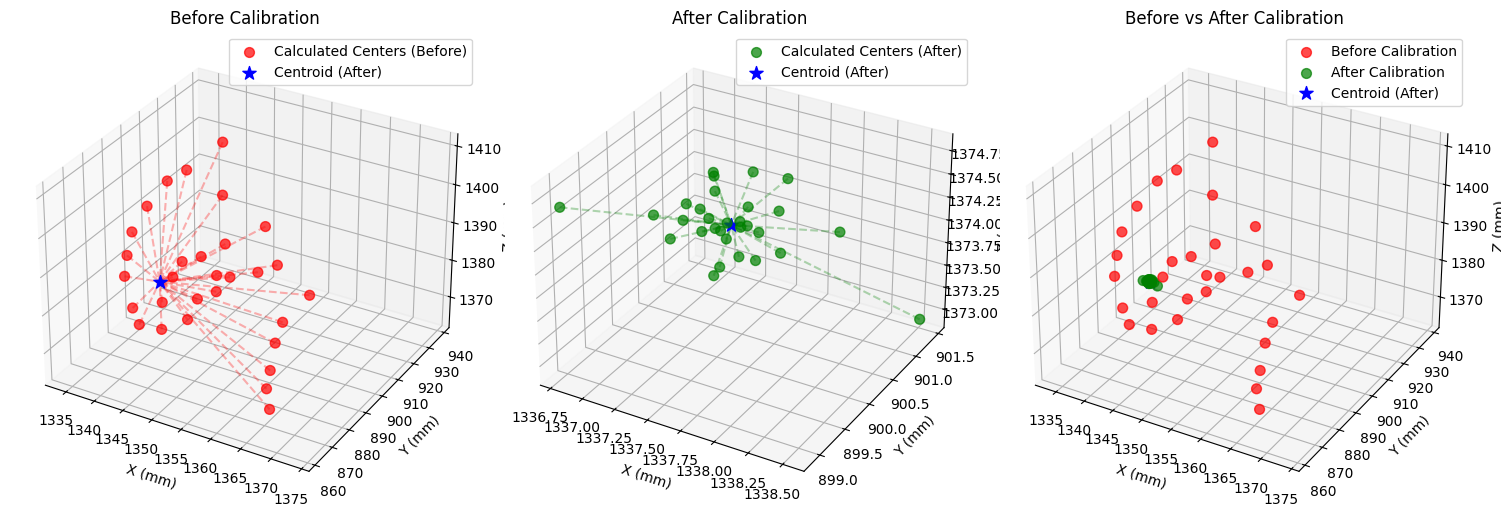


=== High-Precision Calibration Statistics ===
Reference point: Centroid of calibrated data
Reference center: [1337.516, 900.249, 1374.141] mm
Before calibration:
  Mean distance from reference: 37.330 mm
  Std distance from reference: 13.222 mm
  Max distance from reference: 56.467 mm
  Min distance from reference: 9.822 mm

After calibration:
  Mean distance from reference: 0.57906081 mm
  Std distance from reference: 0.39962927 mm
  Max distance from reference: 1.97930370 mm
  Min distance from reference: 0.12600804 mm

Dispersion improvement: 96.98%
Mean distance improvement: 98.45%
Target precision (0.00010000mm): Not achieved
Points within target precision: 0/30 (0.0%)


In [8]:
from main_cali.data_anl import plot_calibration_results, plot_optimization_history

# 绘制校准前后的结果
print("\nGenerating visualization...")
# 现在不需要提供真实球心，函数会自动使用校准后数据的质心作为参考
plot_calibration_results(results)

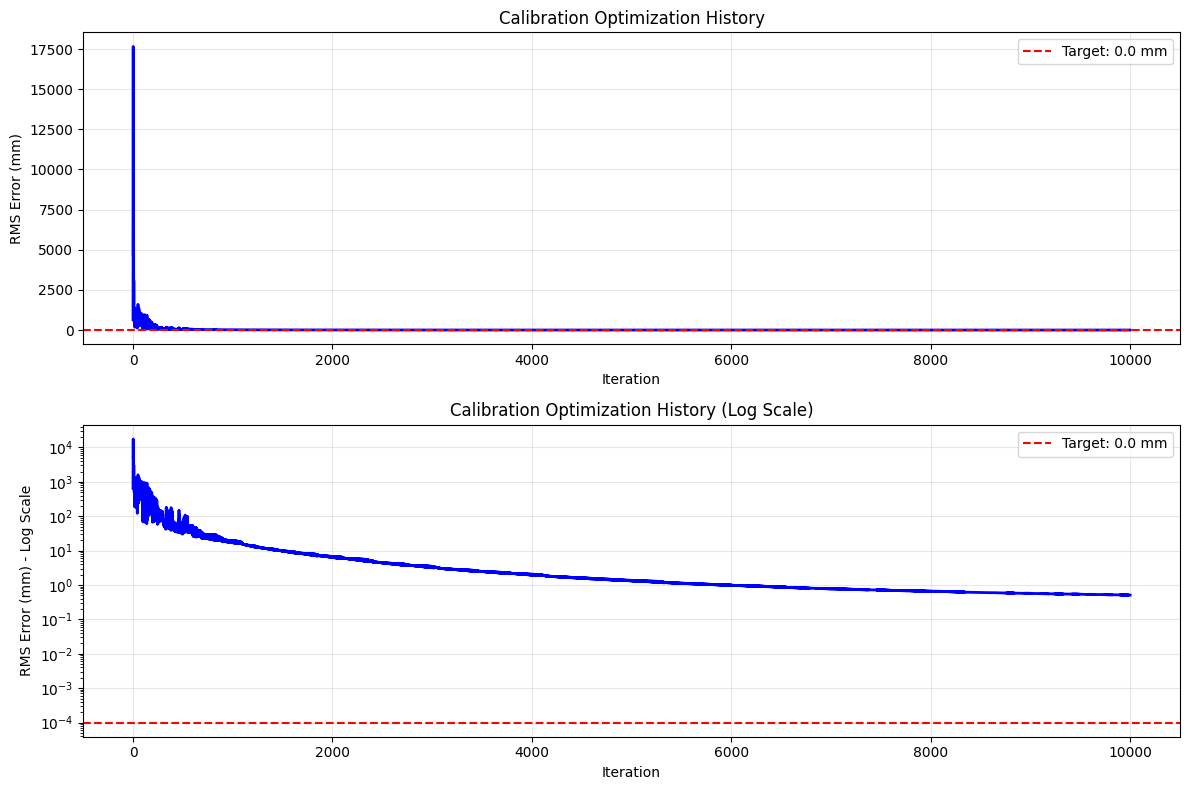

In [9]:
# 绘制优化历史
plot_optimization_history(results)

## 8. 结果分析

In [10]:
# 对比校准前后的机器人参数
print("\n=== Robot Parameters Comparison (Before vs After Calibration) ===")

if 'results' in locals() and results is not None:
    # 从校准结果中获取参数变化信息（使用正确的键名）
    initial_params = results.get('initial_params', {})
    final_params = results.get('final_params', {})
    
    if initial_params and final_params:
        print("\n📊 DH Parameters Changes:")
        print("=" * 80)
        
        # 遍历每个关节的DH参数
        for joint_idx in range(robot.n):
            print(f"\n🔧 Joint {joint_idx + 1} (Link {joint_idx + 1}):")
            print("-" * 40)
            
            # 检查每个DH参数的变化
            dh_params = ['a', 'alpha', 'd', 'beta', 'offset']
            
            for param in dh_params:
                # 校准器使用的格式是 'link_{idx}' -> {param: value}
                link_key = f'link_{joint_idx}'
                
                if (link_key in initial_params and link_key in final_params and
                    param in initial_params[link_key] and param in final_params[link_key]):
                    
                    initial_val = initial_params[link_key][param]
                    final_val = final_params[link_key][param]
                    change = final_val - initial_val
                    
                    # 根据参数类型选择合适的单位和精度
                    if param in ['a', 'd']:
                        unit = "mm"
                        precision = 3
                    else:  # alpha, beta, offset (角度参数)
                        unit = "rad"
                        precision = 6
                    
                    print(f"  {param}: {initial_val:.{precision}f} -> {final_val:.{precision}f} (change: {change:+.{precision}f} {unit})")
                else:
                    print(f"  {param}: Parameter not calibrated")
        
        print("\n" + "=" * 80)
        print("\n🤖 Hand-Eye Parameters Changes:")
        print("-" * 40)
        
        # 手眼参数对比
        hand_eye_params = [
            ('tx', 'mm', 3), ('ty', 'mm', 3), ('tz', 'mm', 3),
            ('rx', 'rad', 6), ('ry', 'rad', 6), ('rz', 'rad', 6)
        ]
        
        for param, unit, precision in hand_eye_params:
            # 校准器使用的格式是 'hand_eye' -> {param: value}
            if ('hand_eye' in initial_params and 'hand_eye' in final_params and
                param in initial_params['hand_eye'] and param in final_params['hand_eye']):
                
                initial_val = initial_params['hand_eye'][param]
                final_val = final_params['hand_eye'][param]
                change = final_val - initial_val
                
                print(f"  {param}: {initial_val:.{precision}f} -> {final_val:.{precision}f} (change: {change:+.{precision}f} {unit})")
            else:
                print(f"  {param}: Parameter not calibrated or not available")
        
        # 计算参数变化的统计信息
        print("\n" + "=" * 80)
        print("\n📈 Parameter Change Statistics:")
        print("-" * 40)
        
        all_changes = []
        significant_changes = []
        
        # 收集所有DH参数变化
        for joint_idx in range(robot.n):
            link_key = f'link_{joint_idx}'
            if link_key in initial_params and link_key in final_params:
                for param in ['a', 'alpha', 'd', 'beta', 'offset']:
                    if param in initial_params[link_key] and param in final_params[link_key]:
                        change = abs(final_params[link_key][param] - initial_params[link_key][param])
                        all_changes.append(change)
                        
                        # 定义显著变化的阈值
                        if param in ['a', 'd']:
                            threshold = 0.1  # mm
                        else:  # alpha, beta, offset
                            threshold = 0.001  # rad
                        
                        if change > threshold:
                            significant_changes.append((f'link_{joint_idx}_{param}', change))
        
        # 收集手眼参数变化
        if 'hand_eye' in initial_params and 'hand_eye' in final_params:
            for param in ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']:
                if param in initial_params['hand_eye'] and param in final_params['hand_eye']:
                    change = abs(final_params['hand_eye'][param] - initial_params['hand_eye'][param])
                    all_changes.append(change)
                    
                    # 定义显著变化的阈值
                    if param in ['tx', 'ty', 'tz']:
                        threshold = 0.1  # mm
                    else:  # rx, ry, rz
                        threshold = 0.001  # rad
                    
                    if change > threshold:
                        significant_changes.append((f'hand_eye_{param}', change))
        
        if all_changes:
            import numpy as np
            print(f"  Total parameters calibrated: {len(all_changes)}")
            print(f"  Mean absolute change: {np.mean(all_changes):.6f}")
            print(f"  Max absolute change: {np.max(all_changes):.6f}")
            print(f"  Min absolute change: {np.min(all_changes):.6f}")
            print(f"  Std of changes: {np.std(all_changes):.6f}")
        
        if significant_changes:
            print(f"\n  Significant changes (> threshold):")
            for param_key, change in sorted(significant_changes, key=lambda x: x[1], reverse=True):
                print(f"    {param_key}: {change:.6f}")
        else:
            print(f"\n  ✅ No significant parameter changes detected")
        
        # 显示当前机器人的最终参数状态
        print("\n" + "=" * 80)
        print("\n🎯 Final Calibrated Robot Parameters:")
        print("-" * 40)
        
        print("\nDH Parameters:")
        for i, link in enumerate(robot.links):
            print(f"  Link {i+1}: a={link.a.item():.3f}mm, d={link.d.item():.3f}mm, "
                  f"alpha={link.alpha.item():.6f}rad, beta={link.beta.item():.6f}rad, "
                  f"offset={link.offset.item():.6f}rad")
        
        print("\nHand-Eye Parameters:")
        print(f"  Translation: tx={robot.tx.item():.3f}mm, ty={robot.ty.item():.3f}mm, tz={robot.tz.item():.3f}mm")
        print(f"  Rotation: rx={robot.rx.item():.6f}rad, ry={robot.ry.item():.6f}rad, rz={robot.rz.item():.6f}rad")
        
    else:
        print("❌ Parameter comparison data not available in calibration results")
        print("Checking available keys in results:")
        print(f"Available keys: {list(results.keys())}")
        
        if 'initial_params' in results:
            print(f"Initial params structure: {results['initial_params']}")
        if 'final_params' in results:
            print(f"Final params structure: {results['final_params']}")

else:
    print("❌ No calibration results available for parameter comparison")
    print("Please run the calibration first (cell 12)")

print("\n" + "=" * 80)


=== Robot Parameters Comparison (Before vs After Calibration) ===

📊 DH Parameters Changes:

🔧 Joint 1 (Link 1):
----------------------------------------
  a: 320.000 -> 317.767 (change: -2.233 mm)
  alpha: -1.570796 -> -1.569128 (change: +0.001669 rad)
  d: 780.000 -> 780.000 (change: +0.000 mm)
  beta: 0.000000 -> 0.000000 (change: +0.000000 rad)
  offset: 0.000000 -> -0.000021 (change: -0.000021 rad)

🔧 Joint 2 (Link 2):
----------------------------------------
  a: 1125.000 -> 1097.622 (change: -27.378 mm)
  alpha: 0.000000 -> 0.008942 (change: +0.008942 rad)
  d: 0.000 -> 0.000 (change: +0.000 mm)
  beta: 0.000000 -> 0.001134 (change: +0.001134 rad)
  offset: -1.570796 -> -1.580671 (change: -0.009875 rad)

🔧 Joint 3 (Link 3):
----------------------------------------
  a: 200.000 -> 196.862 (change: -3.138 mm)
  alpha: -1.570796 -> -1.568771 (change: +0.002026 rad)
  d: -0.000 -> -0.000 (change: +0.000 mm)
  beta: 0.000000 -> 0.000000 (change: +0.000000 rad)
  offset: 0.000000 -> 

In [11]:
# 分析校准结果
print("\n=== Calibration Analysis ===")
print(f"Initial Variance Error: {results['initial_variance_error']:.6f}")
print(f"Final Variance Error: {results['final_variance_error']:.6f}")
print(f"Target Precision (variance): {results['target_precision']:.2e}")
print(f"Precision Achieved: {results['precision_achieved']}")

if results['precision_achieved']:
    print("\n✅ Successfully achieved variance precision target!")
else:
    print("\n❌ Failed to achieve variance precision target")
    print("Consider:")
    print("- Increasing number of samples")
    print("- Reducing measurement noise")
    print("- Adjusting optimization parameters")

# 计算位置标准差(方差的平方根)
import math
initial_std = math.sqrt(results['initial_variance_error'] / 3)  # 除以3是因为x,y,z三个维度
final_std = math.sqrt(results['final_variance_error'] / 3)

print(f"\n=== Position Standard Deviation Analysis ===")
print(f"Initial Position Std Dev: {initial_std:.3f} mm")
print(f"Final Position Std Dev: {final_std:.3f} mm")

if final_std < 1.0:
    print("✅ Position precision is better than 1mm (1σ)")
else:
    print("❌ Position precision is worse than 1mm (1σ)")


=== Calibration Analysis ===
Initial Variance Error: 653.544257
Final Variance Error: 0.512084
Target Precision (variance): 1.00e-04
Precision Achieved: False

❌ Failed to achieve variance precision target
Consider:
- Increasing number of samples
- Reducing measurement noise
- Adjusting optimization parameters

=== Position Standard Deviation Analysis ===
Initial Position Std Dev: 14.760 mm
Final Position Std Dev: 0.413 mm
✅ Position precision is better than 1mm (1σ)


## 9. 标定验证：test_data点云中心方差分析

In [21]:
from robot_model.robots import create_robot
from main_cali.calibrator import RobotCalibrator
import numpy as np
import torch
import copy

print("=== 标定验证：使用test_data进行验证 ===")

# 配置test_data数据路径 - 使用新格式的observations.json文件
test_data_file = os.path.join(os.getcwd(), "data", "main_data", "ABB_1", "observations.json")

print(f"正在加载test_data观测数据...")
print(f"数据文件路径: {test_data_file}")


=== 标定验证：使用test_data进行验证 ===
正在加载test_data观测数据...
数据文件路径: d:\桌面\实习\diff_cali\data\main_data\ABB_1\observations.json


In [22]:
# 检查test_data文件是否存在
if not os.path.exists(test_data_file):
    print(f"❌ 测试数据文件 {test_data_file} 不存在")
    print("请先运行数据预处理程序生成observations.json文件")
else:
    try:
        # 创建临时校准器用于加载测试数据
        temp_calibrator = RobotCalibrator(robot)
        
        # 从JSON文件加载测试数据
        print("正在从JSON文件加载测试观测数据...")
        success = temp_calibrator.load_observations_from_json(test_data_file,10)
        
        if success:
            test_observations = temp_calibrator.observations
            print(f"✓ 成功加载 {len(test_observations)} 个测试观测数据")
            
            # 检查数据格式
            if len(test_observations) > 0:
                sample_obs = test_observations[0]
                has_point_cloud_center = 'point_cloud_center' in sample_obs and sample_obs['point_cloud_center'] is not None
                
                if has_point_cloud_center:
                    print("✓ 测试数据包含点云中心信息，可以进行验证")
                    
                    # 从calibration results获取标定前后的参数
                    if 'results' in locals() and results is not None:
                        initial_params = results.get('initial_params', {})
                        final_params = results.get('final_params', {})
                        
                        if initial_params and final_params:
                            print("\n=== 创建标定前后的机器人模型 ===")
                            
                            # 创建标定前的机器人模型（使用初始参数）
                            robot_before = create_robot(robot_name=robot_name)
                            
                            # 应用初始参数
                            for joint_idx in range(robot_before.n):
                                link_key = f'link_{joint_idx}'
                                if link_key in initial_params:
                                    link_params = initial_params[link_key]
                                    for param_name, param_value in link_params.items():
                                        if hasattr(robot_before.links[joint_idx], param_name):
                                            # 使用.data属性来更新torch.nn.Parameter的值
                                            current_attr = getattr(robot_before.links[joint_idx], param_name)
                                            if isinstance(current_attr, torch.nn.Parameter):
                                                current_attr.data = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                            elif isinstance(current_attr, torch.Tensor):
                                                new_tensor = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                                setattr(robot_before.links[joint_idx], param_name, new_tensor)
                            
                            # 应用初始手眼参数
                            if 'hand_eye' in initial_params:
                                he_params = initial_params['hand_eye']
                                for param_name, param_value in he_params.items():
                                    if hasattr(robot_before, param_name):
                                        # 使用.data属性来更新torch.nn.Parameter的值
                                        current_attr = getattr(robot_before, param_name)
                                        if isinstance(current_attr, torch.nn.Parameter):
                                            current_attr.data = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                        elif isinstance(current_attr, torch.Tensor):
                                            new_tensor = torch.tensor(param_value, dtype=current_attr.dtype, device=current_attr.device)
                                            setattr(robot_before, param_name, new_tensor)
                            
                            print("✓ 标定前机器人模型已创建")
                            
                            # 标定后的机器人模型就是当前的robot
                            robot_after = robot
                            print("✓ 标定后机器人模型已准备就绪")
                            
                            # 使用标定器的方差计算方法
                            def calculate_point_cloud_variance_with_calibrator(robot_model, observations):
                                """使用标定器的方差计算方法计算点云中心转换到基坐标系后的方差"""
                                # 创建临时标定器，使用相同的参数和排除规则
                                temp_calibrator = RobotCalibrator(robot_model)
                                
                                # 设置观测数据
                                temp_calibrator.set_observations(observations)
                                
                                # 调用标定器的方差计算方法
                                variance_error = temp_calibrator._compute_variance_error()
                                
                                # 获取转换后的点云中心位置用于可视化
                                transformed_centers = []
                                for obs in observations:
                                    joint_angles = obs['joint_state']
                                    point_cloud_center = obs['point_cloud_center']
                                    
                                    if point_cloud_center is not None:
                                        # 点云中心已经预计算好了
                                        if isinstance(point_cloud_center, np.ndarray):
                                            pc_center = point_cloud_center
                                        else:
                                            pc_center = np.array(point_cloud_center)
                                        
                                        # 将点云中心转换为齐次坐标
                                        pc_center_homo = np.append(pc_center, 1.0)
                                        
                                        # 确保关节角度是正确的数据类型
                                        if isinstance(joint_angles, np.ndarray):
                                            joint_angles = joint_angles.astype(np.float64)
                                        elif isinstance(joint_angles, list):
                                            joint_angles = np.array(joint_angles, dtype=np.float64)
                                        
                                        # 通过机器人正运动学获得末端到基坐标系的变换矩阵
                                        T_base_to_end = robot_model.fkine(joint_angles)
                                        
                                        # 将相机坐标系的点转换到基坐标系
                                        # 确保数据类型匹配
                                        pc_center_tensor = torch.tensor(pc_center_homo, dtype=T_base_to_end.dtype, device=T_base_to_end.device)
                                        pc_center_base = T_base_to_end @ pc_center_tensor
                                        
                                        # 只保留xyz坐标
                                        transformed_centers.append(pc_center_base[:3].detach().numpy())
                                
                                if len(transformed_centers) == 0:
                                    return 0.0, np.array([])
                                
                                transformed_centers = np.array(transformed_centers)
                                
                                return variance_error, transformed_centers
                            
                            print("\n=== 使用标定器方法计算标定前后点云中心方差 ===")
                            
                            # 计算标定前的方差
                            print("正在使用标定器方法计算标定前的点云中心方差...")
                            variance_before, centers_before = calculate_point_cloud_variance_with_calibrator(robot_before, test_observations)
                            
                            # 计算标定后的方差
                            print("正在使用标定器方法计算标定后的点云中心方差...")
                            variance_after, centers_after = calculate_point_cloud_variance_with_calibrator(robot_after, test_observations)
                            
                            print(f"\n=== 验证结果 ===")
                            print(f"测试数据点数: {len(test_observations)}")
                            print(f"标定前点云中心方差: {variance_before.item():.6f} mm²")
                            print(f"标定后点云中心方差: {variance_after.item():.6f} mm²")
                            print(f"方差改善: {(variance_before.item() - variance_after.item()):.6f} mm² ({((variance_before.item() - variance_after.item())/variance_before.item()*100):.2f}%)")
                            
                            # 计算标准差
                            std_before = np.sqrt(variance_before.item())
                            std_after = np.sqrt(variance_after.item())
                            print(f"\n标定前点云中心标准差: {std_before:.3f} mm")
                            print(f"标定后点云中心标准差: {std_after:.3f} mm")
                            print(f"标准差改善: {std_before - std_after:.3f} mm ({((std_before - std_after)/std_before*100):.2f}%)")
                            
                            # 判断是否达到目标精度
                            if std_after < 1.0:
                                print("\n✅ 验证成功：标定后点云中心标准差 < 1mm")
                            else:
                                print("\n⚠️  验证结果：标定后点云中心标准差仍 > 1mm")
                            
                            # 保存验证数据供后续可视化使用
                            validation_data = {
                                'centers_before': centers_before,
                                'centers_after': centers_after,
                                'variance_before': variance_before.item(),
                                'variance_after': variance_after.item(),
                                'std_before': std_before,
                                'std_after': std_after
                            }
                            
                            print("✓ 验证数据已保存，可用于后续可视化")
                            
                        else:
                            print("❌ 无法获取标定前后的参数数据")
                    else:
                        print("❌ 未找到标定结果，请先运行标定")
                else:
                    print("❌ 测试数据不包含点云中心信息，无法进行验证")
            else:
                print("❌ 测试数据为空")
        else:
            print("❌ 测试数据加载失败")
    
    except Exception as e:
        print(f"❌ 验证过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

正在从JSON文件加载测试观测数据...
Loaded 10 observations with precomputed centers
✓ 成功从 d:\桌面\实习\diff_cali\data\main_data\ABB_1\observations.json 加载 10 个观测数据 (共 23 个)
✓ 成功加载 10 个测试观测数据
✓ 测试数据包含点云中心信息，可以进行验证

=== 创建标定前后的机器人模型 ===
✓ 标定前机器人模型已创建
✓ 标定后机器人模型已准备就绪

=== 使用标定器方法计算标定前后点云中心方差 ===
正在使用标定器方法计算标定前的点云中心方差...
Loaded 10 observations with precomputed centers
正在使用标定器方法计算标定后的点云中心方差...
Loaded 10 observations with precomputed centers

=== 验证结果 ===
测试数据点数: 10
标定前点云中心方差: 542.411740 mm²
标定后点云中心方差: 1.860063 mm²
方差改善: 540.551676 mm² (99.66%)

标定前点云中心标准差: 23.290 mm
标定后点云中心标准差: 1.364 mm
标准差改善: 21.926 mm (94.14%)

⚠️  验证结果：标定后点云中心标准差仍 > 1mm
✓ 验证数据已保存，可用于后续可视化



=== 可视化验证结果 ===


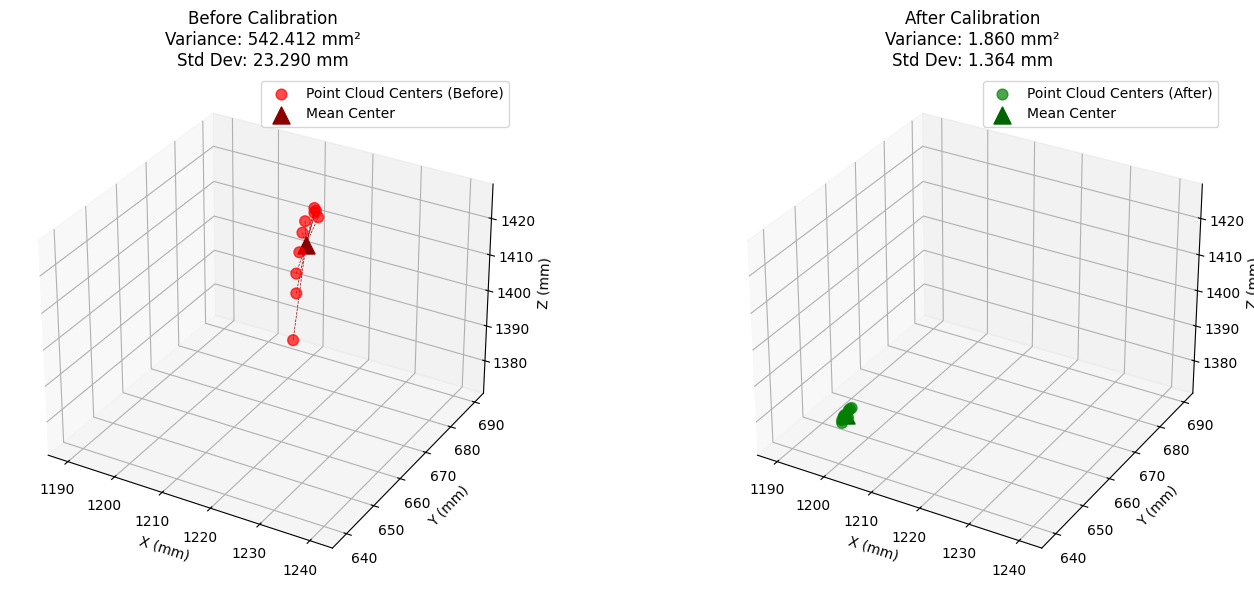

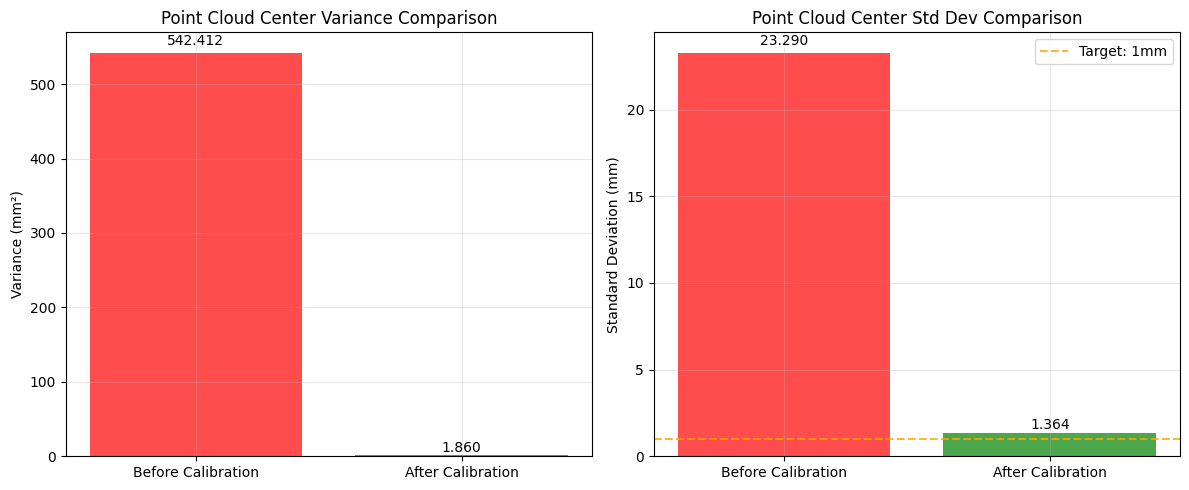


=== 详细统计对比 ===
测试样本数量: 10

标定前统计:
  中心位置: [1221.38, 666.22, 1421.68] mm
  X轴范围: 1208.66 ~ 1236.50 mm (span: 27.84 mm)
  Y轴范围: 634.99 ~ 693.71 mm (span: 58.73 mm)
  Z轴范围: 1407.74 ~ 1428.14 mm (span: 20.40 mm)

标定后统计:
  中心位置: [1193.96, 652.00, 1373.12] mm
  X轴范围: 1193.69 ~ 1194.38 mm (span: 0.69 mm)
  Y轴范围: 650.73 ~ 654.17 mm (span: 3.44 mm)
  Z轴范围: 1371.78 ~ 1373.77 mm (span: 2.00 mm)

=== 改善情况 ===
方差改善: 99.66%
标准差改善: 94.14%
❌ 未达标：标定后标准差 1.364mm > 1mm 目标


In [23]:
# 可视化验证结果
if 'validation_data' in locals():
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    print("\n=== 可视化验证结果 ===")
    
    centers_before = validation_data['centers_before']
    centers_after = validation_data['centers_after']
    
    if len(centers_before) > 0 and len(centers_after) > 0:
        # 创建3D对比图
        fig = plt.figure(figsize=(15, 6))
        
        # 标定前的分布
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(centers_before[:, 0], centers_before[:, 1], centers_before[:, 2], 
                   c='red', alpha=0.7, s=60, label='Point Cloud Centers (Before)')
        
        
        # 计算并显示中心点
        center_before = np.mean(centers_before, axis=0)
        ax1.scatter(center_before[0], center_before[1], center_before[2], 
                   c='darkred', s=150, marker='^', label='Mean Center')
        
        # 从每个点到中心的连线
        for i, pos in enumerate(centers_before):
            ax1.plot([pos[0], center_before[0]], [pos[1], center_before[1]], [pos[2], center_before[2]], 
                    'darkred', alpha=1, linewidth=0.5, linestyle='--')
        
        ax1.set_xlabel('X (mm)')
        ax1.set_ylabel('Y (mm)')
        ax1.set_zlabel('Z (mm)')
        ax1.set_title(f'Before Calibration\nVariance: {validation_data["variance_before"]:.3f} mm²\nStd Dev: {validation_data["std_before"]:.3f} mm')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 标定后的分布
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(centers_after[:, 0], centers_after[:, 1], centers_after[:, 2], 
                   c='green', alpha=0.7, s=60, label='Point Cloud Centers (After)')
        
        
        # 计算并显示中心点
        center_after = np.mean(centers_after, axis=0)
        ax2.scatter(center_after[0], center_after[1], center_after[2], 
                   c='darkgreen', s=150, marker='^', label='Mean Center')
        
        # 从每个点到中心的连线
        for i, pos in enumerate(centers_after):
            ax2.plot([pos[0], center_after[0]], [pos[1], center_after[1]], [pos[2], center_after[2]], 
                    'darkgreen', alpha=1, linewidth=0.5, linestyle='--')
        
        ax2.set_xlabel('X (mm)')
        ax2.set_ylabel('Y (mm)')
        ax2.set_zlabel('Z (mm)')
        ax2.set_title(f'After Calibration\nVariance: {validation_data["variance_after"]:.3f} mm²\nStd Dev: {validation_data["std_after"]:.3f} mm')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 设置相同的坐标轴范围以便对比
        all_centers = np.vstack([centers_before, centers_after])
        for ax in [ax1, ax2]:
            max_range = np.array([all_centers[:,0].max()-all_centers[:,0].min(),
                                  all_centers[:,1].max()-all_centers[:,1].min(),
                                  all_centers[:,2].max()-all_centers[:,2].min()]).max() / 2.0
            mid_x = (all_centers[:,0].max()+all_centers[:,0].min()) * 0.5
            mid_y = (all_centers[:,1].max()+all_centers[:,1].min()) * 0.5
            mid_z = (all_centers[:,2].max()+all_centers[:,2].min()) * 0.5
            
            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)
        
        plt.tight_layout()
        plt.show()
        
        # 创建统计对比图
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # 方差对比
        categories = ['Before Calibration', 'After Calibration']
        variances = [validation_data['variance_before'], validation_data['variance_after']]
        colors = ['red', 'green']
        
        bars1 = ax1.bar(categories, variances, color=colors, alpha=0.7)
        ax1.set_ylabel('Variance (mm²)')
        ax1.set_title('Point Cloud Center Variance Comparison')
        ax1.grid(True, alpha=0.3)
        
        # 在柱状图上添加数值标签
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        # 标准差对比
        std_devs = [validation_data['std_before'], validation_data['std_after']]
        bars2 = ax2.bar(categories, std_devs, color=colors, alpha=0.7)
        ax2.set_ylabel('Standard Deviation (mm)')
        ax2.set_title('Point Cloud Center Std Dev Comparison')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=1.0, color='orange', linestyle='--', alpha=0.8, label='Target: 1mm')
        ax2.legend()
        
        # 在柱状图上添加数值标签
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # 打印详细统计信息
        print(f"\n=== 详细统计对比 ===")
        print(f"测试样本数量: {len(centers_before)}")
        print(f"\n标定前统计:")
        print(f"  中心位置: [{center_before[0]:.2f}, {center_before[1]:.2f}, {center_before[2]:.2f}] mm")
        print(f"  X轴范围: {centers_before[:,0].min():.2f} ~ {centers_before[:,0].max():.2f} mm (span: {centers_before[:,0].max()-centers_before[:,0].min():.2f} mm)")
        print(f"  Y轴范围: {centers_before[:,1].min():.2f} ~ {centers_before[:,1].max():.2f} mm (span: {centers_before[:,1].max()-centers_before[:,1].min():.2f} mm)")
        print(f"  Z轴范围: {centers_before[:,2].min():.2f} ~ {centers_before[:,2].max():.2f} mm (span: {centers_before[:,2].max()-centers_before[:,2].min():.2f} mm)")
        
        print(f"\n标定后统计:")
        print(f"  中心位置: [{center_after[0]:.2f}, {center_after[1]:.2f}, {center_after[2]:.2f}] mm")
        print(f"  X轴范围: {centers_after[:,0].min():.2f} ~ {centers_after[:,0].max():.2f} mm (span: {centers_after[:,0].max()-centers_after[:,0].min():.2f} mm)")
        print(f"  Y轴范围: {centers_after[:,1].min():.2f} ~ {centers_after[:,1].max():.2f} mm (span: {centers_after[:,1].max()-centers_after[:,1].min():.2f} mm)")
        print(f"  Z轴范围: {centers_after[:,2].min():.2f} ~ {centers_after[:,2].max():.2f} mm (span: {centers_after[:,2].max()-centers_after[:,2].min():.2f} mm)")
        
        # 计算改善百分比
        variance_improvement = (validation_data['variance_before'] - validation_data['variance_after']) / validation_data['variance_before'] * 100
        std_improvement = (validation_data['std_before'] - validation_data['std_after']) / validation_data['std_before'] * 100
        
        print(f"\n=== 改善情况 ===")
        print(f"方差改善: {variance_improvement:.2f}%")
        print(f"标准差改善: {std_improvement:.2f}%")
        
        if validation_data['std_after'] < 1.0:
            print(f"✅ 验证通过：标定后标准差 {validation_data['std_after']:.3f}mm < 1mm 目标")
        else:
            print(f"❌ 未达标：标定后标准差 {validation_data['std_after']:.3f}mm > 1mm 目标")
            
    else:
        print("❌ 没有足够的数据进行可视化")
else:
    print("❌ 未找到验证数据，请先运行上一个验证单元")